# Data Analyst Nanodegree
## Project 5: Machine Learning - Enron POI 

Stephan Teodorovich
May, 2018

## Section 1 - Data Preparation

This section will include the coding and data wrangling/analysis for understanding the Enron Email POI. Review of the data, conclusions, and answers to the project questions are in the accompanying document. 

### 1.1: Importing modules and initial code

I'll get started with the pre-written poi_id.py code to ensure that the all of the proper modules/libraries are imported and in place so we can begin to check out the dataset provided.

In [14]:
import sys
import pickle
import numpy 
import pandas as pd
import sklearn
from time import time
from copy import copy


#import ggplot
#from ggplot import *
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

 

import warnings
warnings.filterwarnings('ignore')

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import test_classifier, dump_classifier_and_data
import enron 
import evaluate


numpy.random.seed(42)

### 1.2: Create features list

The next step is to create a features list, and then follow that with a look a the information present, using Jeffrey Skilling as an example.

In [2]:
## Create features list
features_list = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 
                 'loan_advances', 'bonus', 'restricted_stock_deferred', 
                 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 
                 'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi', 
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees'] 

### Load the dictionary containing the dataset
enron_data = pickle.load(open("final_project_dataset.pkl", "r") )


## Load POI names file
fpoi = open("poi_names.txt", "r")

# Print available information for Jeffrey Skilling
print enron_data["SKILLING JEFFREY K"]

{'salary': 1111258, 'to_messages': 3627, 'deferral_payments': 'NaN', 'total_payments': 8682716, 'exercised_stock_options': 19250000, 'bonus': 5600000, 'restricted_stock': 6843672, 'shared_receipt_with_poi': 2042, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 26093672, 'expenses': 29336, 'loan_advances': 'NaN', 'from_messages': 108, 'other': 22122, 'from_this_person_to_poi': 30, 'poi': True, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 1920000, 'email_address': 'jeff.skilling@enron.com', 'from_poi_to_this_person': 88}


### 1.3:  Determine Dataset Size

Now that we have an idea of what information is present in the dataset, it's a good idea to just take a look at the overall structure, including size, features, the number of POIs already identified, and total POIs.

In [3]:
# People in the dataset

people = len(enron_data)
print "There are " + str(people) + " people in the dataset."

There are 146 people in the dataset.


In [4]:
#Features in the dataset

features = len(enron_data['SKILLING JEFFREY K'])
print "There are " + str(features) + " features in the dataset."

There are 21 features in the dataset.


In [5]:
def poi_counter(file):
    count = 0 
    for person in file:
        if file[person]['poi'] == True:
            count += 1
    print "There are " + str(count) + " POIs in the dataset."

poi_counter(enron_data)

There are 18 POIs in the dataset.


In [6]:
fpoi = open("poi_names.txt", "r")
rfile = fpoi.readlines()
poi = len(rfile[2:])
print "There were " + str(poi) + " poi's total."

There were 35 poi's total.


Before we get into any sort of cleaning or data manipulation, it's a good idea to just review what we know so far about the dataset:
<ul>
<li>There are 146 entries</li>
<li>There are 21 features</li>
<li>There are <i>NaN</i> entries present</li>
<li>There are 18 POIs in the dataset</li>
</ul>

We don't know how frequent NaN entries are, or if they are consistent between all entries.  We also don't know if all of the entries represent unique individuals, whether there are duplicates, or whether some of the entries are not actual people.  We should tackle these problems one at a time.

## Section 2 - Data Evaluation and Cleaning

Now we can start to take a deeper look at exactly what is in this dataset, and how much of it needs to be mended.

### 2.1: NaN Entries

As seen above, there are some features that have NaN entries.  It's probably a good idea to do a quick check of a couple of features to see just how widespread these are.  I'll take a look at two features: <b>restricted_stock</b> and <b>loan_advances</b>

Before we can do that, we need to create a pandas dataframe from the dataset.


In [7]:
# Load the dataset

with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

# Convert dictionary into a pandas dataframe

df = pd.DataFrame.from_records(list(data_dict.values()))
employees = pd.Series(list(data_dict.keys()))
df.set_index(employees, inplace = True)

Now we can check <b>restricted_stock</b>:

In [8]:
df['restricted_stock'].value_counts()

NaN          36
126027        5
315068        3
441096        3
189041        3
360528        2
378082        2
869220        2
384930        1
208809        1
363428        1
235370        1
698920        1
365320        1
560170        1
563798        1
659249        1
307301        1
462384        1
3942714       1
4188667       1
405999        1
466101        1
-2604490      1
2041016       1
417619        1
514847        1
47304         1
1293424       1
386335        1
             ..
480632        1
630137        1
151418        1
130322299     1
956775        1
1478269       1
14761694      1
213063        1
208510        1
153686        1
1392142       1
576792        1
524169        1
259907        1
207940        1
1552453       1
662086        1
388167        1
853064        1
2748364       1
950730        1
32460         1
264013        1
4131594       1
407503        1
558801        1
409554        1
2217299       1
511734        1
540672        1
Name: restricted_stock, 

Next, we'll give <b>loan_advances</b> a look:

In [9]:
df['loan_advances'].value_counts()

NaN         142
83925000      1
81525000      1
2000000       1
400000        1
Name: loan_advances, dtype: int64

Look at that!  142 instances nf NaN!  Clearly this is something we will have to contend with later in this project.  To prepare for it, I will now convert NaN to zero within the pandas dataframe.


In [10]:
df.replace('NaN', 0, inplace=True)

And now just to confirm the replacement is done

In [11]:
df['loan_advances'].value_counts()

0           142
400000        1
83925000      1
2000000       1
81525000      1
Name: loan_advances, dtype: int64

All instances of NaN have been replaced.

Now we can move on to looking for outliers

### 2.2: Identifying and removing Outliers

When trying to determine outliers, it seems sensible to focus on the financial aspect, as the entire Enron scandal was essentially based on greed.

There are several criteria we can apply, but I will start with creating a scatterplot of <b>Total Payments</b> and <b>Total Stock Value</b>.

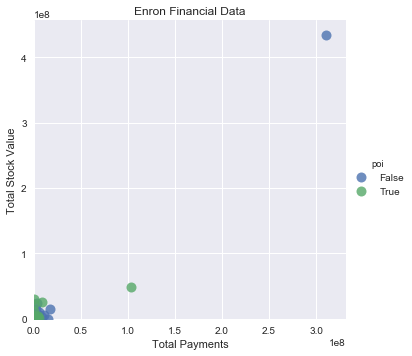

In [16]:
# Create scatterplots of 'total_stock_value' vs. 'total_payments'

g = sns.lmplot('total_payments', 'total_stock_value', 
           data=df, 
           fit_reg=False, 
           hue='poi',
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Enron Financial Data')
plt.xlabel('Total Payments')
plt.ylabel('Total Stock Value')

g.set(ylim=(0, None))
g.set(xlim=(0, None))

There are two easily identifiable outlying data points here, one with a False POI and one True:
<ul>
<li>The False POI outlier shows a total stock value of over \$400 million, and a total payments of over \$300 million.</li>
<li>The True outlier is less extreme, but still sticks out with a total stock value of approximately \$50 million, and total payments of just over \$100 million.</li>
</ul>

I'll now go ahead and identify these two outliers using Total Payments as the criteria, as both points are clearly identifiable as being greater than \$100 million (1.0e8)


In [17]:
df[df['total_payments']>1.0e8].index.tolist()

['LAY KENNETH L', 'TOTAL']

The two points are identifued as 'Kenneth Lay' and 'Total', with 'Total' being the higher value.

The <i>enron61702insiderpay.pdf</i> document included in our information indicates that 'Total' is just the aggregate payout for all of the people in the dataset, and therefore is not relevant to any future analysis and will bias the machine learning phase. The presenence of 'Total" in the dataset leads me to wonder whether there are any other entries that do not correspond to a person. Fortunately, another non-person entry, 'The Travel Agency In The Park' was quickly located (it was immediately above 'Total"). A review of the pdf did not reveal any other suspicious entries.

I will go ahead and take a closer look at the data for both 'Total' and 'The Travel Agency In The Park' by printing out the values:


In [18]:
print df[df.index == 'TOTAL'].values
print df[df.index == 'THE TRAVEL AGENCY IN THE PARK'].values

[[97343619L 32083396L -27992891L 1398517L 0 311764000L 5235198L 0L 0L 0L
  83925000L 48521928L 42667589L False 130322299L -7576788L 26704229L 0L 0L
  309886585L 434509511L]]
[[0L 0L 0L 0L 0 0L 0L 0L 0L 0L 0L 0L 362096L False 0L 0L 0L 0L 0L 362096L
  0L]]


As expected, **Total** showed values for every financial field, and no values for any email-related field. However, **Travel Agency** did show a value for 'Other'.

The Footnotes in the PDF showed that:

<blockquote>Payments were made by Enron employees on account of business-related travel to The Travel Agency In The Park ... which was co-owned by the sister of Enron's former Chairman.</blockquote>

Interesting. However, although this does add to the evidence of an overall culture of greed and corruption, this entry is not relevant to the purpose of this investigation, and so I will eliminate the **Travel Agency** entry from the dataset along with **Travel**.


In [19]:
# Remove Travel Agency and Total from dataset

df = df.drop(['TOTAL', 'THE TRAVEL AGENCY IN THE PARK'])

I will now create a new scatterplot from the adjusted dataset.

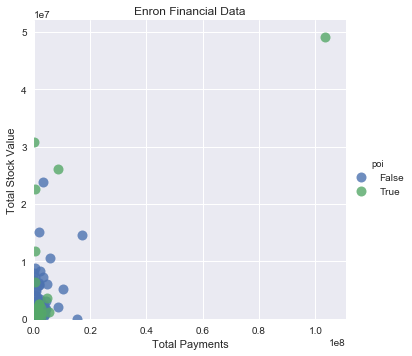

In [20]:
# Re-plot the data

g = sns.lmplot('total_payments', 'total_stock_value', 
           data=df, 
           fit_reg=False, 
           hue='poi',
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Enron Financial Data')
plt.xlabel('Total Payments')
plt.ylabel('Total Stock Value')

g.set(xlim=(0, None))
g.set(ylim=(0, None))

The Ken Lay outlier is still present and now all on its own. However, removing this point from the dataset would seem to sabotage the very purpose of the exercise, as he is likely the POI. Nonetheless, re-sizing the X and Y axis may provide an interesting view, and could possibly identify other potential POIs.

I'll re-set the X axis to an upper-limit of 0.3e8, and the Y-axis to 3.5e7

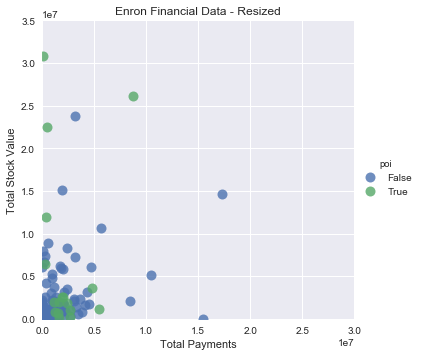

In [21]:
# Change axis scale

g = sns.lmplot('total_payments', 'total_stock_value', 
           data=df, 
           fit_reg=False, 
           hue='poi',
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Enron Financial Data - Resized')
plt.xlabel('Total Payments')
plt.ylabel('Total Stock Value')

g.set(ylim=(0, 3.5e7))
g.set(xlim=(0, 0.3e8))

This view shows a much less concentrated plot, and while most of the datapoints are still clustered along the lower-left corner (0 to 1.0e7 for both X and Y), there are no unambiguous outliers - though one might be able to construct an argument for one or two points.

There are no longer any obvious outliers. Next, I would like to conduct a 'sanity' check on the data. According to the PDF provided with the project, the **'total_payments'** field should be equal to the sum of nine different fields and the **'total_stock_value'** field should be equal to the sum of three other fields. I will now confirm that this holds true in the dataset.

### 2.2.1 Data Validity Check
In order to confirm that the dataset is accurate (and partly out of curiosity), I think it would be interesting to check to see whether the dataset is accurate.

The pdf document would lead one to believe that the 'Total Payments' field should be equal to the sum of the previous nine Payment fields. Similarly, the 'Total Stock Value' field should be equal to the sum of the three Stock Value fields. Let's try and confirm that.

We'll start by looking at **Total Payments**. We'll create a new variable 'tp' which will be the sum of the nine Payment fields, and compare that to the **Total Payments** field value:

In [22]:
# Create a new tp variable to compare against total_payments
# tp will be the sum of the nine 'Payment" fields:
# salary, bonus, long_term_incentive, deferred_income, deferral_payments
# loan_advances, other, expenses, and director_fees

'''
Full Feature list:

features_list = ['poi','salary', 'deferral_payments', 'total_payments', 
'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 
'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 
'long_term_incentive', 'restricted_stock', 'director_fees','to_messages', 
'email_address', 'from_poi_to_this_person', 'from_messages', 
'from_this_person_to_poi', 'shared_receipt_with_poi']
'''

df['tp'] = df['total_payments']-(
    df['salary']+df['bonus']+df['long_term_incentive']+df['deferred_income']+
 df['deferral_payments']+df['loan_advances']+df['other']+df['expenses']+df['director_fees'])

... and I'll also do the same for **Total Stock Value** by creating a new 'tsv' variable

In [23]:
df['tsv'] = df['total_stock_value']-(
    df['exercised_stock_options']+df['restricted_stock']+df['restricted_stock_deferred'])

Now to run the test.

In [24]:
print "Value count for 'total_payment' test failing:"
print df['tp'][df['tp']!=0].value_counts()

print "Value count for 'total_stock_value' test failing:"
print df['tsv'][df['tsv']!=0].value_counts()

Value count for 'total_payment' test failing:
201715      1
15180562    1
Name: tp, dtype: int64
Value count for 'total_stock_value' test failing:
-91471       1
-15456290    1
Name: tsv, dtype: int64


The results indicate that something is wrong. Both Total Stock Value and Total Payments are not equal to the sum of their individual components, with one discrepancy of about \$15 million.

We can try and identify which row(s) is/are responsible for the errors. We'll set our limit using the smaller numbers (~ \$200K and ~\$91K)

In [25]:
# Identify the source(s) of the error

print df[df['tp']>2e5].index.tolist()
print df[df['tsv']<-9e4].index.tolist()

['BELFER ROBERT', 'BHATNAGAR SANJAY']
['BELFER ROBERT', 'BHATNAGAR SANJAY']


What we see are two entries, Robert Belfer and Sanjay Bhatnagar. In order to simplify things, let's just reset our test and focus on the \$15 million dollar question:

In [26]:
# Identify the source(s) of the $15 million error

print df[df['tp']>1e7].index.tolist()
print df[df['tsv']<-1e7].index.tolist()

['BHATNAGAR SANJAY']
['BHATNAGAR SANJAY']


On first glance it looks like Sanjay may be up to no good. Let's take a closer look at his data:

In [27]:
df[df.index == 'BHATNAGAR SANJAY'].drop(['poi','to_messages', 
'email_address', 'from_poi_to_this_person', 'from_messages', 
'from_this_person_to_poi', 'shared_receipt_with_poi'],axis=1)

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,total_payments,total_stock_value,tp,tsv
BHATNAGAR SANJAY,0,0,0,137864,2604490,0,0,0,137864,-2604490,15456290,0,15456290,0,15180562,-15456290


I checked this data against the pdf and found that there is an error in data entry. For example, in this data the 'Director Fees' shows \$137,864, but in the pdf that value falls under 'Expenses'.

Rather than just deleting this data, I will instead repair it in the dataset using the pdf as a guide.

I will also use this as a cautionary tale about reaching a premature conclusion, and judging books ...

In [28]:
# Repair the data for Sanjay Bhatnagar

df.loc['BHATNAGAR SANJAY','director_fees'] = 0
df.loc['BHATNAGAR SANJAY','exercised_stock_options'] = 15456290
df.loc['BHATNAGAR SANJAY','expenses'] = 137864
df.loc['BHATNAGAR SANJAY','other'] = 0
df.loc['BHATNAGAR SANJAY','restricted_stock'] = 2604490
df.loc['BHATNAGAR SANJAY','restricted_stock_deferred'] = -2604490
df.loc['BHATNAGAR SANJAY','total_payments'] = 137864
df.loc['BHATNAGAR SANJAY','total_stock_value'] = 15456290

# Run the TP_test and TSV_test calculations again

df['tp'] = df['total_payments']-(df['salary']+df['bonus']+df['long_term_incentive']+df['deferred_income']+
df['deferral_payments']+df['loan_advances']+df['other']+df['expenses']+df['director_fees'])

df['tsv'] = df['total_stock_value']-(df['exercised_stock_options']+df['restricted_stock']+
                                          df['restricted_stock_deferred'])
    
# Confirm that Sanjay Bhatnagar's data looks correct now
                                 
df[df.index == 'BHATNAGAR SANJAY'].drop(['poi','to_messages', 
'email_address', 'from_poi_to_this_person', 'from_messages', 
'from_this_person_to_poi', 'shared_receipt_with_poi'],axis=1)

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,total_payments,total_stock_value,tp,tsv
BHATNAGAR SANJAY,0,0,0,0,15456290,137864,0,0,0,2604490,-2604490,0,137864,15456290,0,0


Much better.

But remember, we also had another erroneous set of data for Robert Belfer. We can take a look at his data, which I suspect suffers from the same problem with incorrect entry:

In [29]:
# Check Robert Belfer's data

df[df.index == 'BELFER ROBERT'].drop(['poi','to_messages', 
'email_address', 'from_poi_to_this_person', 'from_messages', 
'from_this_person_to_poi', 'shared_receipt_with_poi'],axis=1)

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,total_payments,total_stock_value,tp,tsv
BELFER ROBERT,0,-102500,0,3285,3285,0,0,0,0,0,44093,0,102500,-44093,201715,-91471


As I did with Sanjay, I checked this data against the pdf and found a mismatch in entry. I will go ahead and correct it now and run a check.

In [30]:
# Repoair the data for Robert Belfer

df.loc['BELFER ROBERT','deferral_payments'] = 0
df.loc['BELFER ROBERT','deferred_income'] = -102500
df.loc['BELFER ROBERT','director_fees'] = 102500
df.loc['BELFER ROBERT','exercised_stock_options'] = 0
df.loc['BELFER ROBERT','expenses'] = 3285
df.loc['BELFER ROBERT','restricted_stock'] = 44093
df.loc['BELFER ROBERT','restricted_stock_deferred'] = -44093
df.loc['BELFER ROBERT','total_payments'] = 3285
df.loc['BELFER ROBERT','total_stock_value'] = 0

# Run the TP_test and TSV_test calculations again

df['tp'] = df['total_payments']-(df['salary']+df['bonus']+df['long_term_incentive']+df['deferred_income']+
df['deferral_payments']+df['loan_advances']+df['other']+df['expenses']+df['director_fees'])

df['tsv'] = df['total_stock_value']-(df['exercised_stock_options']+df['restricted_stock']+
                                          df['restricted_stock_deferred'])
    
# Confirm that Robert Belfer's data looks correct now
    
df[df.index == 'BELFER ROBERT'].drop(['poi','to_messages', 
'email_address', 'from_poi_to_this_person', 'from_messages', 
'from_this_person_to_poi', 'shared_receipt_with_poi'],axis=1)

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,total_payments,total_stock_value,tp,tsv
BELFER ROBERT,0,0,-102500,102500,0,3285,0,0,0,44093,-44093,0,3285,0,0,0


There. Things look better.

Now I can go ahead and run the original comparison between the stated Total Payment and Total Stock Value entries versus the sum of their parts:

In [31]:
# Print the updated TP_test and TSV_test results

print "Value count for 'total_payment' test failing:"
print df['tp'][df['tp']!=0].value_counts()

print "Value count for 'total_stock_value' test failing:"
print df['tsv'][df['tsv']!=0].value_counts()

Value count for 'total_payment' test failing:
Series([], Name: tp, dtype: int64)
Value count for 'total_stock_value' test failing:
Series([], Name: tsv, dtype: int64)


In [32]:
# Print the updated TP_test and TSV_test results

print "Value count for 'total_payment' test failing:"
print df['tp'][df['tp']!=0].value_counts()

print "Value count for 'total_stock_value' test failing:"
print df['tsv'][df['tsv']!=0].value_counts()

Value count for 'total_payment' test failing:
Series([], Name: tp, dtype: int64)
Value count for 'total_stock_value' test failing:
Series([], Name: tsv, dtype: int64)


The discrepancies have been eliminated. That's more like it. Now we can proceed to the next step

### Checking for Outliers in Emal data

Now that we've checked out the financial side for outliers, it might be worthwhile to check the email-related features for the same thing.  

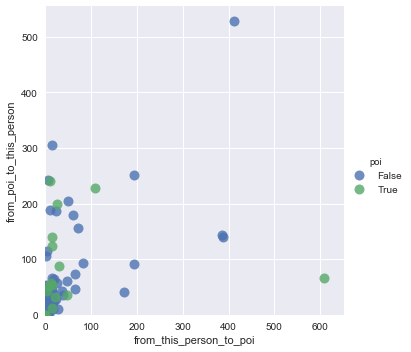

In [33]:
# Create email scatterplot

g = sns.lmplot('from_this_person_to_poi', 'from_poi_to_this_person', 
           data=df, 
           fit_reg=False, 
           hue='poi',
           scatter_kws={"marker": "D", 
                       "s": 100})


g.set(xlim=(0, None))
g.set(ylim=(0, None))



Yes, we do see outliers.  Interestingly, there is one datapoint identified as a POI who has sent over 600 emails to another POI, while there is one person not identified as a POI who has received over 500 emails from a POI.  Maybe we can try and idenfity the two of them.

Frr this, I will look at all valuds greater than 400 for **from_this_person_to_poi**

In [34]:
df[df['from_this_person_to_poi']>400].index.tolist()

['LAVORATO JOHN J', 'DELAINEY DAVID W']

Both of these are actual people, and so they will remain in the dataset, even if they are outliers.

### 2.3 Reviewing the data

Okay, now that we've dealt with the NaN entries, and have identified two non-human entries from the dataset, we can take a quick look at the data to see what wev'e got here.

In [35]:
print df.head()

                    bonus  deferral_payments  deferred_income  director_fees  \
METTS MARK         600000                  0                0              0   
BAXTER JOHN C     1200000            1295738         -1386055              0   
ELLIOTT STEVEN     350000                  0          -400729              0   
CORDES WILLIAM R        0                  0                0              0   
HANNON KEVIN P    1500000                  0         -3117011              0   

                             email_address  exercised_stock_options  expenses  \
METTS MARK            mark.metts@enron.com                        0     94299   
BAXTER JOHN C                            0                  6680544     11200   
ELLIOTT STEVEN    steven.elliott@enron.com                  4890344     78552   
CORDES WILLIAM R     bill.cordes@enron.com                   651850         0   
HANNON KEVIN P      kevin.hannon@enron.com                  5538001     34039   

                  from_messages 

... and take a look at the data types

In [36]:
df.dtypes

bonus                         int64
deferral_payments             int64
deferred_income               int64
director_fees                 int64
email_address                object
exercised_stock_options       int64
expenses                      int64
from_messages                 int64
from_poi_to_this_person       int64
from_this_person_to_poi       int64
loan_advances                 int64
long_term_incentive           int64
other                         int64
poi                            bool
restricted_stock              int64
restricted_stock_deferred     int64
salary                        int64
shared_receipt_with_poi       int64
to_messages                   int64
total_payments                int64
total_stock_value             int64
tp                            int64
tsv                           int64
dtype: object

... and lastly, just get an overall description of the data.

In [37]:

df_imp = df.fillna(0).copy(deep=True)
df_imp.columns = list(df.columns.values)
print df_imp.isnull().sum()
print df_imp.head()

df_imp.describe()

bonus                        0
deferral_payments            0
deferred_income              0
director_fees                0
email_address                0
exercised_stock_options      0
expenses                     0
from_messages                0
from_poi_to_this_person      0
from_this_person_to_poi      0
loan_advances                0
long_term_incentive          0
other                        0
poi                          0
restricted_stock             0
restricted_stock_deferred    0
salary                       0
shared_receipt_with_poi      0
to_messages                  0
total_payments               0
total_stock_value            0
tp                           0
tsv                          0
dtype: int64
                    bonus  deferral_payments  deferred_income  director_fees  \
METTS MARK         600000                  0                0              0   
BAXTER JOHN C     1200000            1295738         -1386055              0   
ELLIOTT STEVEN     350000         

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,...,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,tp,tsv
count,1.440000e+02,1.440000e+02,1.440000e+02,144.000000,1.440000e+02,144.000000,144.000000,144.000000,144.000000,1.440000e+02,...,1.440000e+02,1.440000e+02,1.440000e+02,1.440000e+02,144.000000,144.000000,1.440000e+02,1.440000e+02,144.0,144.0
mean,6.759974e+05,2.228014e+05,-1.943951e+05,9711.923611,2.165028e+06,36355.541667,363.583333,38.756944,24.625000,5.828125e+05,...,2.937881e+05,9.050160e+05,-5.261658e+04,1.854460e+05,702.611111,1238.555556,2.149476e+06,3.017427e+06,0.0,0.0
std,1.233155e+06,7.538411e+05,6.058422e+05,30422.534940,4.923320e+06,45990.417225,1450.675239,74.276769,79.778266,6.794472e+06,...,1.131517e+06,2.000357e+06,2.731835e+05,1.970421e+05,1077.290736,2237.564816,8.779364e+06,6.271528e+06,0.0,0.0
min,0.000000e+00,0.000000e+00,-3.504386e+06,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,-2.604490e+06,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0
25%,0.000000e+00,0.000000e+00,-3.907200e+04,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,4.409300e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,8.747150e+04,2.563765e+05,0.0,0.0
50%,3.000000e+05,0.000000e+00,0.000000e+00,0.000000,6.082935e+05,21937.000000,17.500000,4.000000,0.000000,0.000000e+00,...,8.825000e+02,3.619780e+05,0.000000e+00,2.105960e+05,114.000000,347.500000,9.138250e+05,9.805345e+05,0.0,0.0
75%,8.000000e+05,8.535500e+03,0.000000e+00,0.000000,1.683580e+06,54234.500000,53.000000,41.250000,14.000000,0.000000e+00,...,1.485770e+05,8.571030e+05,0.000000e+00,2.696675e+05,933.750000,1623.000000,1.885158e+06,2.372703e+06,0.0,0.0
max,8.000000e+06,6.426990e+06,0.000000e+00,125034.000000,3.434838e+07,228763.000000,14368.000000,528.000000,609.000000,8.152500e+07,...,1.035973e+07,1.476169e+07,0.000000e+00,1.111258e+06,5521.000000,15149.000000,1.035598e+08,4.911008e+07,0.0,0.0


## Section 3 - Feature Selection

We now have 23 features present for entry (the original 21 plus the two I created to check the data validity), there are a lot of combinations to consider.  Rather than make blind assumptions that could be faulty or spend an inordinate amount of time running through the possibilities, we can start by creating a pair grid to see if anything leaps out.

But first, let's get rid of the 'tp' and 'tsv' variables:

In [38]:
# Remove tp and tsv

df = df.drop(['tp', 'tsv'],axis=1)

And check to see they are gone:

In [39]:
df.describe()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,1.440000e+02,1.440000e+02,1.440000e+02,144.000000,1.440000e+02,144.000000,144.000000,144.000000,144.000000,1.440000e+02,1.440000e+02,1.440000e+02,1.440000e+02,1.440000e+02,1.440000e+02,144.000000,144.000000,1.440000e+02,1.440000e+02
mean,6.759974e+05,2.228014e+05,-1.943951e+05,9711.923611,2.165028e+06,36355.541667,363.583333,38.756944,24.625000,5.828125e+05,3.369578e+05,2.937881e+05,9.050160e+05,-5.261658e+04,1.854460e+05,702.611111,1238.555556,2.149476e+06,3.017427e+06
std,1.233155e+06,7.538411e+05,6.058422e+05,30422.534940,4.923320e+06,45990.417225,1450.675239,74.276769,79.778266,6.794472e+06,6.871826e+05,1.131517e+06,2.000357e+06,2.731835e+05,1.970421e+05,1077.290736,2237.564816,8.779364e+06,6.271528e+06
min,0.000000e+00,0.000000e+00,-3.504386e+06,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.604490e+06,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,-3.907200e+04,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.409300e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,8.747150e+04,2.563765e+05
50%,3.000000e+05,0.000000e+00,0.000000e+00,0.000000,6.082935e+05,21937.000000,17.500000,4.000000,0.000000,0.000000e+00,0.000000e+00,8.825000e+02,3.619780e+05,0.000000e+00,2.105960e+05,114.000000,347.500000,9.138250e+05,9.805345e+05
75%,8.000000e+05,8.535500e+03,0.000000e+00,0.000000,1.683580e+06,54234.500000,53.000000,41.250000,14.000000,0.000000e+00,3.745862e+05,1.485770e+05,8.571030e+05,0.000000e+00,2.696675e+05,933.750000,1623.000000,1.885158e+06,2.372703e+06
max,8.000000e+06,6.426990e+06,0.000000e+00,125034.000000,3.434838e+07,228763.000000,14368.000000,528.000000,609.000000,8.152500e+07,5.145434e+06,1.035973e+07,1.476169e+07,0.000000e+00,1.111258e+06,5521.000000,15149.000000,1.035598e+08,4.911008e+07


Perfect!  Now we can create that pair grid

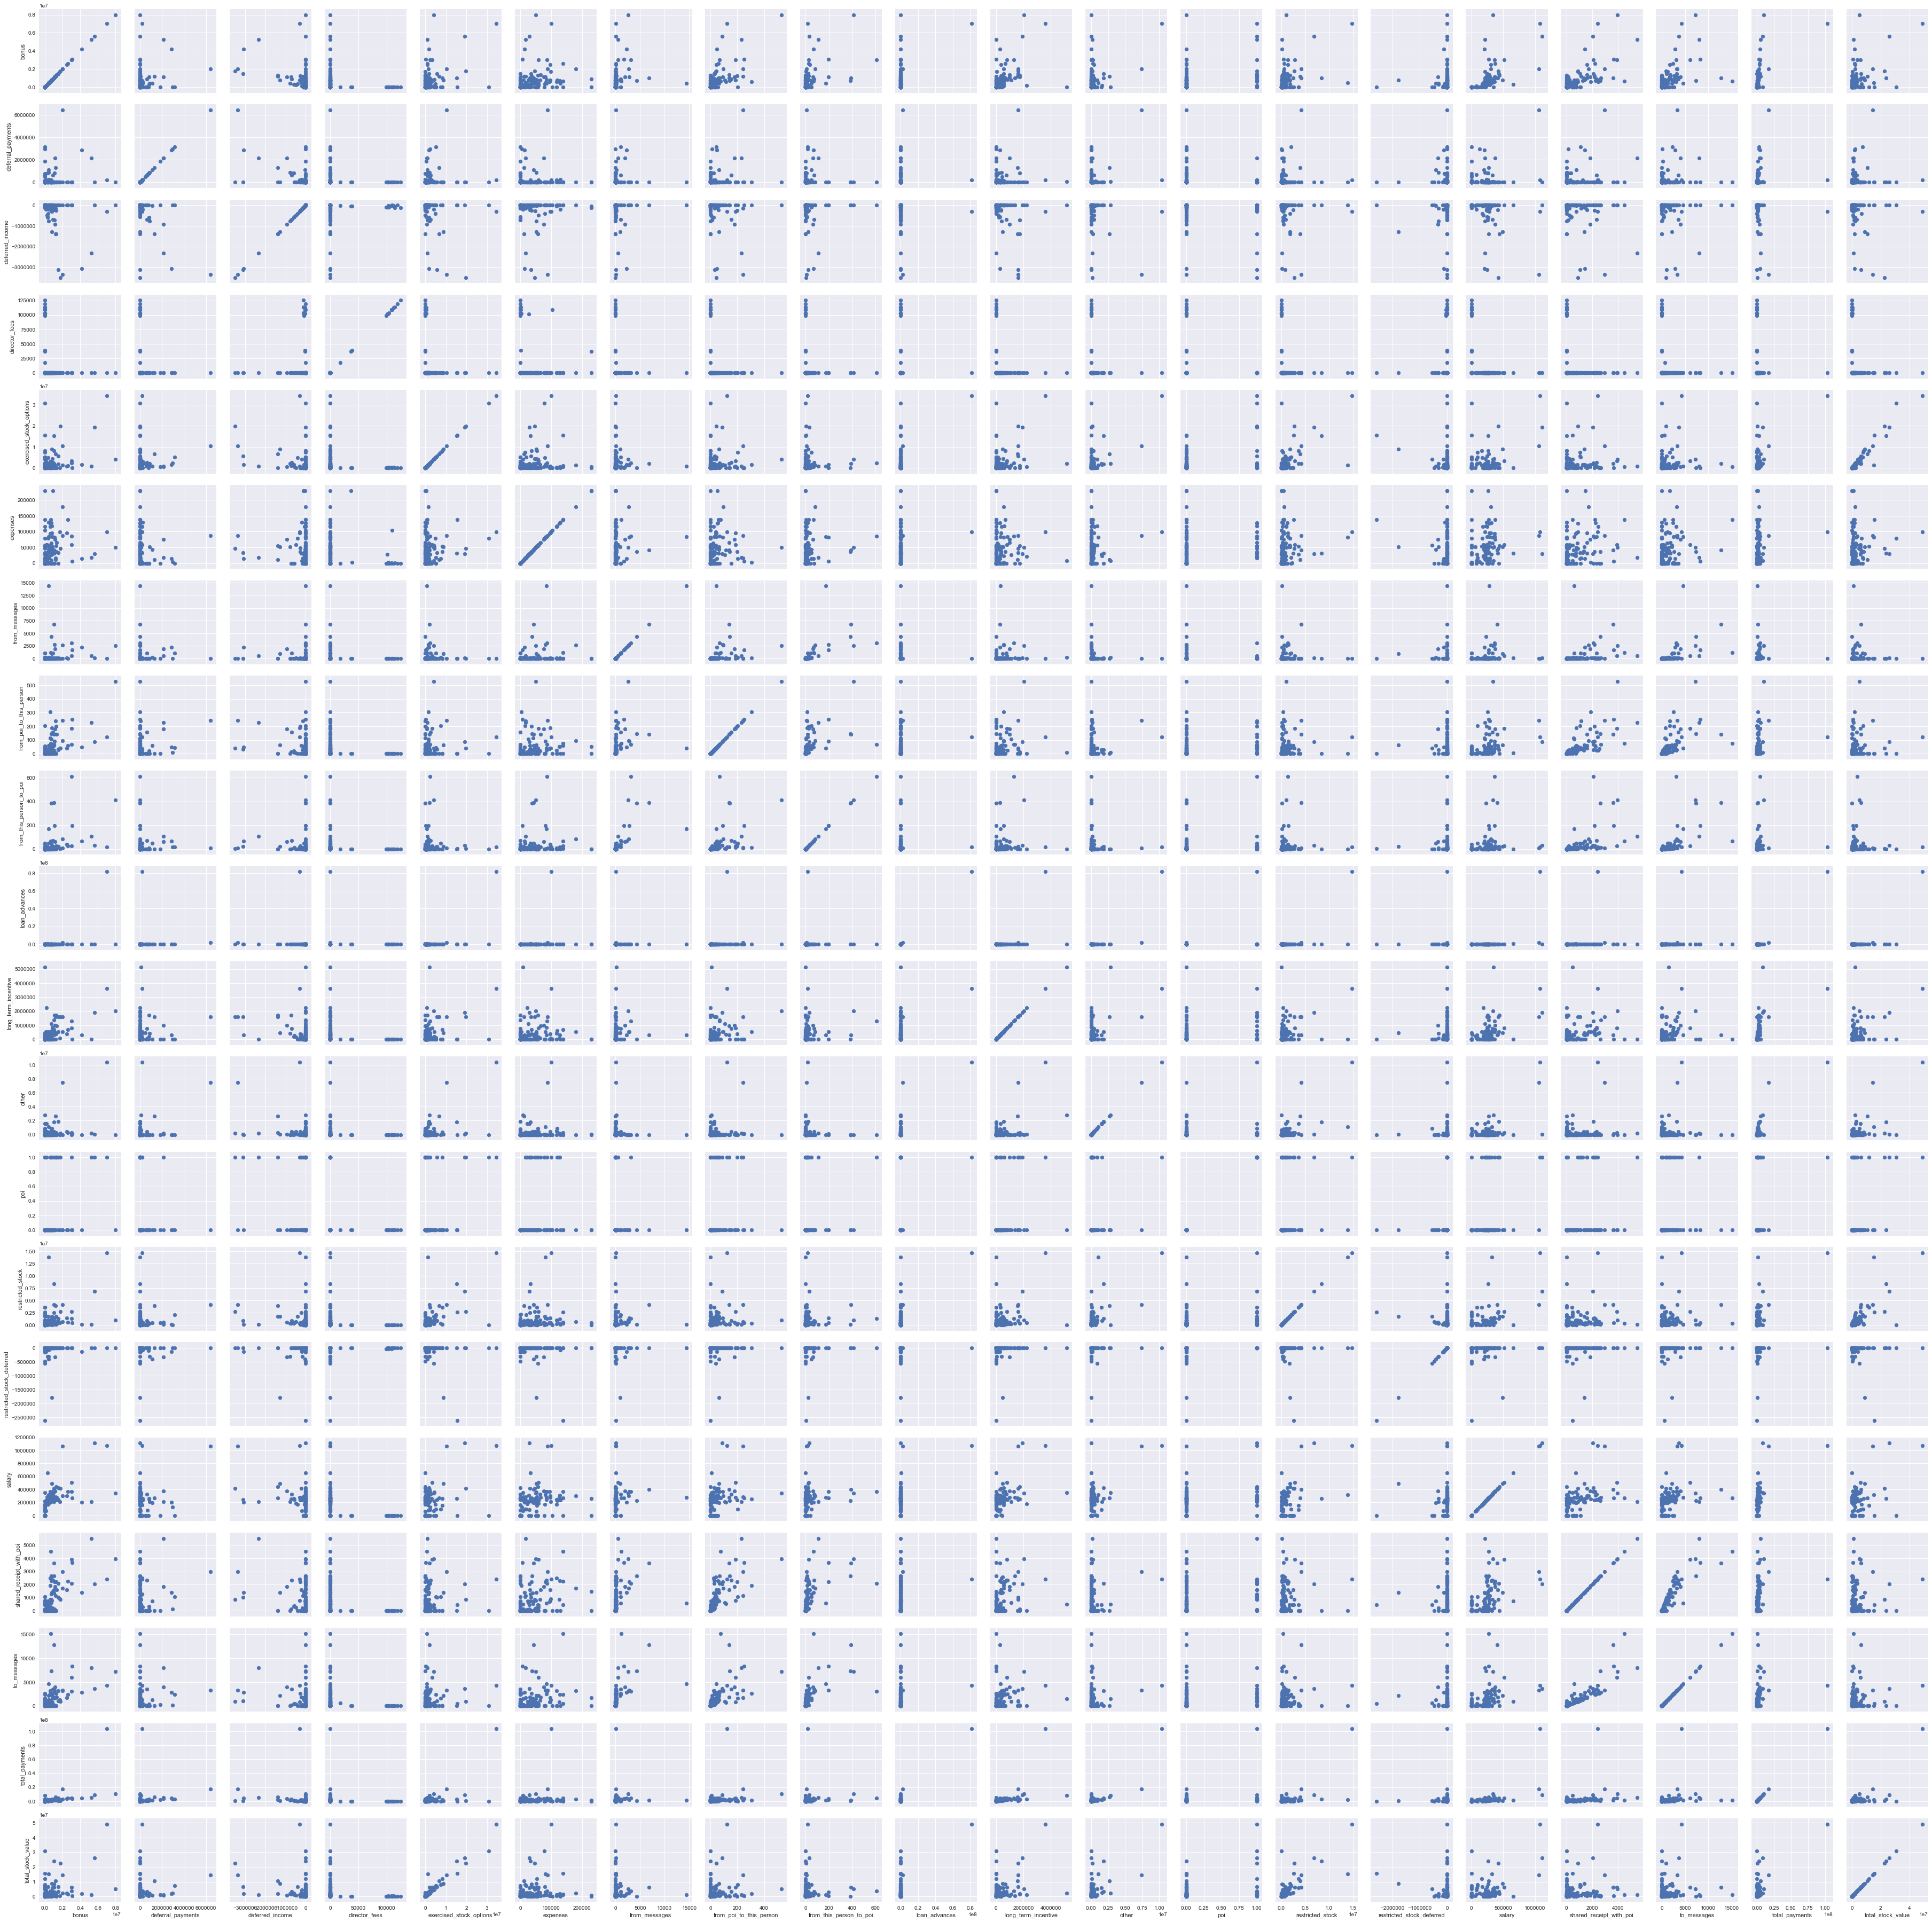

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.PairGrid(df)
g.map(plt.scatter);

Okay.  Well, sometimes a pair grid doesn't actually identify a clear winning pair. However, we can try other options to identify relevant features.

Let's give a heatmap a shot to see if it shows us anything.

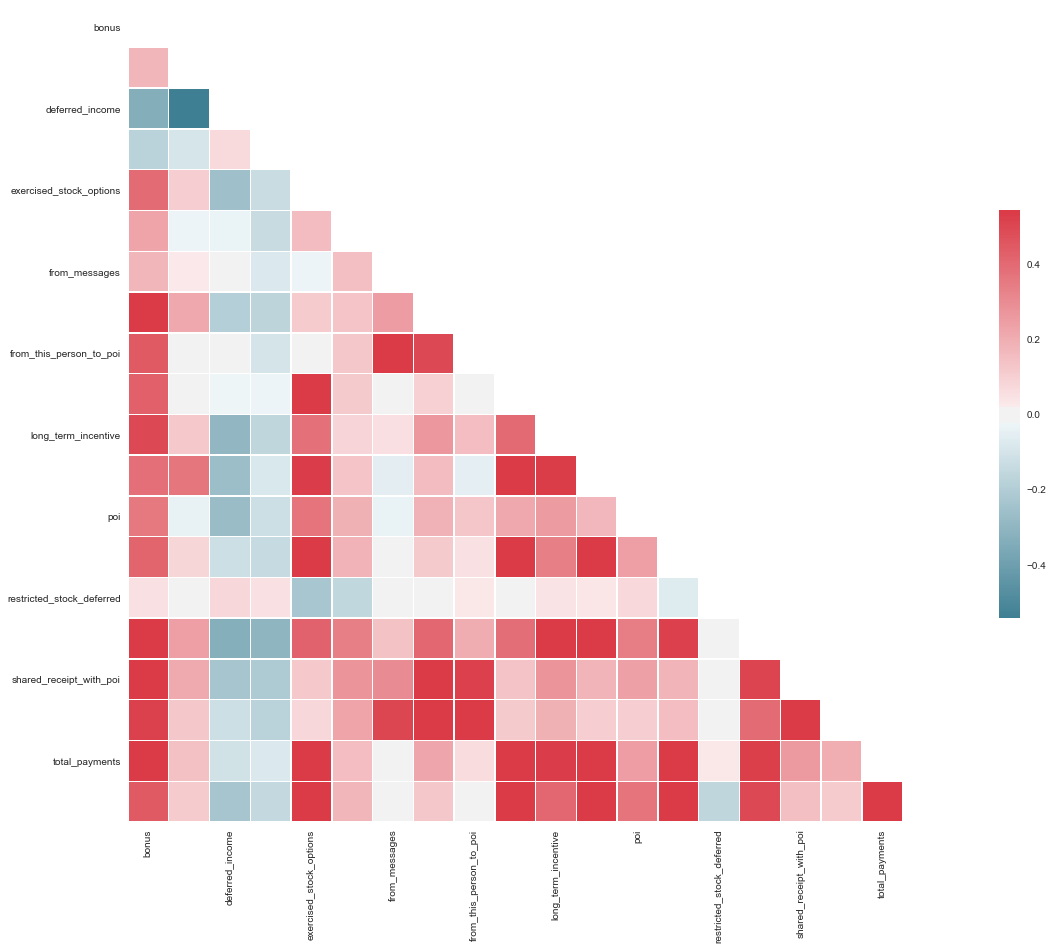

In [41]:
from string import letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=2, yticklabels=2,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

These results aren't much better than the pair grid.  Perhaps we can do a correlation analysis applying the Pearson's test. 

In [42]:
df.corr(method='pearson')

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
bonus,1.000000,0.174234,-0.331193,-0.176223,0.395945,0.230693,0.174601,0.641137,0.448719,0.432387,0.497976,0.384063,0.359381,0.417344,0.048771,0.649638,0.665151,0.520081,0.570852,0.446067
deferral_payments,0.174234,1.000000,-0.543102,-0.095011,0.109159,-0.026918,0.028913,0.216814,0.002082,0.014606,0.119527,0.369107,-0.039439,0.083523,-0.007665,0.242796,0.210063,0.124209,0.146070,0.111999
deferred_income,-0.331193,-0.543102,1.000000,0.071536,-0.255512,-0.033321,-0.014550,-0.194655,-0.004628,-0.025273,-0.296064,-0.265698,-0.274393,-0.121167,0.079521,-0.329212,-0.236069,-0.121439,-0.108438,-0.235767
director_fees,-0.176223,-0.095011,0.071536,1.000000,-0.135225,-0.137722,-0.080497,-0.167739,-0.099227,-0.027575,-0.157630,-0.083466,-0.121080,-0.144002,0.051381,-0.302548,-0.209617,-0.176767,-0.076457,-0.149848
exercised_stock_options,0.395945,0.109159,-0.255512,-0.135225,1.000000,0.160011,-0.026926,0.113172,-0.002803,0.551773,0.380110,0.531630,0.370618,0.594268,-0.229342,0.421058,0.119238,0.077853,0.582470,0.964584
expenses,0.230693,-0.026918,-0.033321,-0.137722,0.160011,1.000000,0.148584,0.134841,0.126283,0.118034,0.085924,0.131880,0.193956,0.183660,-0.155575,0.335881,0.278663,0.232954,0.155163,0.177416
from_messages,0.174601,0.028913,-0.014550,-0.080497,-0.026926,0.148584,1.000000,0.253745,0.609586,-0.019518,0.055461,-0.054111,-0.033982,0.018843,0.000458,0.144043,0.301490,0.508196,0.011997,-0.015108
from_poi_to_this_person,0.641137,0.216814,-0.194655,-0.167739,0.113172,0.134841,0.253745,1.000000,0.497979,0.100622,0.267400,0.161030,0.190460,0.117429,0.020067,0.407349,0.733038,0.618484,0.224063,0.127173
from_this_person_to_poi,0.448719,0.002082,-0.004628,-0.099227,-0.002803,0.126283,0.609586,0.497979,1.000000,-0.009679,0.156910,-0.048985,0.129619,0.054840,0.031479,0.206959,0.524710,0.605306,0.066327,0.016662
loan_advances,0.432387,0.014606,-0.025273,-0.027575,0.551773,0.118034,-0.019518,0.100622,-0.009679,1.000000,0.402060,0.759306,0.220295,0.584426,0.016637,0.387788,0.137421,0.115600,0.972716,0.620289


That table is a bit tough to make any sense of, since a 21x21 grid has a lot of stuff.  But we can create a correlation plot that is similar in function to the heatmap.  Maybe that will show us the way.

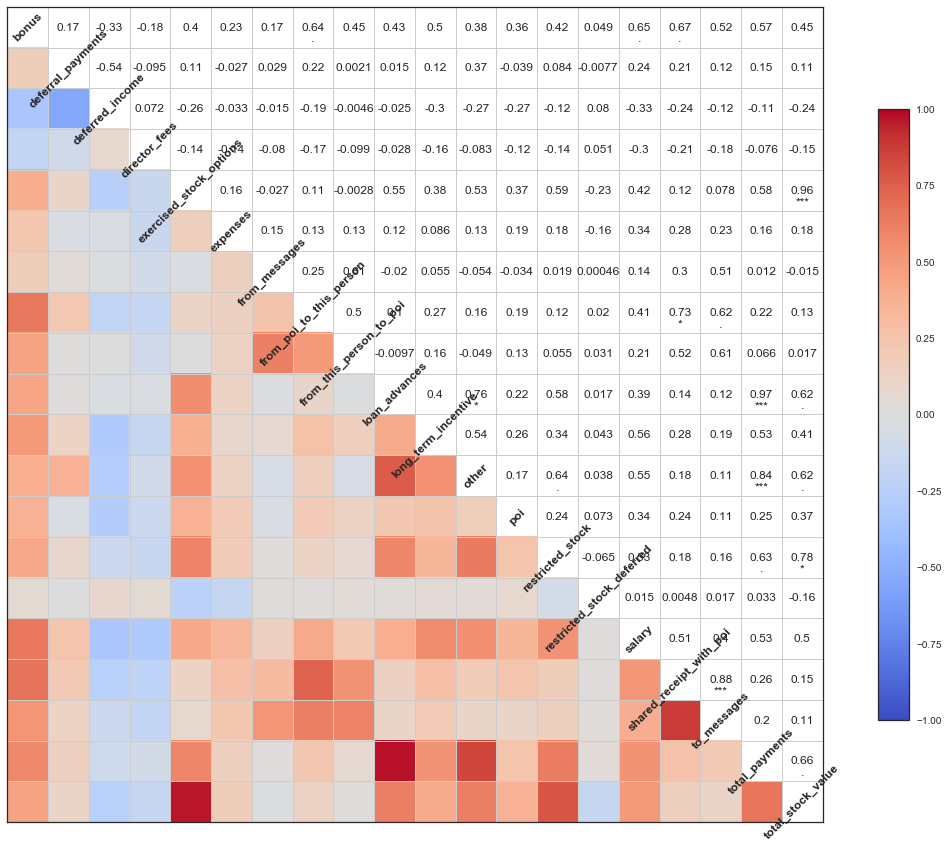

In [43]:
# Set up the matplotlib figure
from seaborn.linearmodels import corrplot,symmatplot
f, ax = plt.subplots(figsize=(20, 15))

corrplot(df) # compute and plot the pair-wise correlations
# save to file, remove the big white borders
plt.savefig('attribute_correlations.png', tight_layout=True)

Unfortunately, while this graph is a bit more helpful than the heatmap, it still isn't 100% clear.  It may be time to just default to using scikit-learn and their SelectKBest module.

### 3.1 Use scikit-learn's SelectKBest feature selection:

In [44]:
def get_k_best(enron_data, features_list, k):
    """ runs scikit-learn's SelectKBest feature selection
        returns dict where keys=features, values=scores
    """
    data = featureFormat(enron_data, features_list)
    labels, features = targetFeatureSplit(data)

    k_best = SelectKBest(k=k)
    k_best.fit(features, labels)
    scores = k_best.scores_
    unsorted_pairs = zip(features_list[1:], scores)
    sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))
    k_best_features = dict(sorted_pairs[:k])
    print "{0} best features: {1}\n".format(k, k_best_features.keys())
    print k_best_features
    return k_best_features

In [45]:
# get K-best features
target_label = 'poi'
from sklearn.feature_selection import SelectKBest
num_features = 10 # 10 best features
best_features = get_k_best(enron_data, features_list, num_features)
print best_features
my_feature_list = [target_label] + best_features.keys()
# print my_feature_list

print "{0} selected features: {1}\n".format(len(my_feature_list) - 1, my_feature_list[1:])

10 best features: ['to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'director_fees', 'loan_advances', 'from_this_person_to_poi', 'deferred_income', 'shared_receipt_with_poi', 'from_poi_to_this_person']

{'to_messages': 1.7516942790340737, 'deferral_payments': 0.23899588985313305, 'total_payments': 0.34962715304280179, 'exercised_stock_options': 0.22826733729104948, 'director_fees': 0.54908420147980874, 'loan_advances': 2.5182610445203437, 'from_this_person_to_poi': 2.470521222656084, 'deferred_income': 0.21950572394230994, 'shared_receipt_with_poi': 8.9038215571655712, 'from_poi_to_this_person': 5.4466874833253529}
{'to_messages': 1.7516942790340737, 'deferral_payments': 0.23899588985313305, 'total_payments': 0.34962715304280179, 'exercised_stock_options': 0.22826733729104948, 'director_fees': 0.54908420147980874, 'loan_advances': 2.5182610445203437, 'from_this_person_to_poi': 2.470521222656084, 'deferred_income': 0.21950572394230994, 'shared_receipt_wit

Finally some clarity!  

But we also need to consider whether or not new features that we create and add to the dataset would be of help.  

### 3.2: New Features

Given the fact that we want to try and help identify POIs from the email data, my new features are going to focus on that aspect.

In [46]:
import warnings
warnings.filterwarnings('ignore')

#Engineerd Features are:
new_feat1='poi_ratio'
new_feat2='fraction_to_poi'
new_feat3='fraction_from_poi'


# add'em
enron.add_poi_ratio(enron_data, my_feature_list)
enron.add_fraction_to_poi(enron_data, my_feature_list)
enron.add_fraction_from_poi(enron_data, my_feature_list)


new_feature_list=my_feature_list 
print my_feature_list
print new_feature_list


['poi', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'director_fees', 'loan_advances', 'from_this_person_to_poi', 'deferred_income', 'shared_receipt_with_poi', 'from_poi_to_this_person', 'poi_ratio', 'fraction_to_poi', 'fraction_from_poi']
['poi', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'director_fees', 'loan_advances', 'from_this_person_to_poi', 'deferred_income', 'shared_receipt_with_poi', 'from_poi_to_this_person', 'poi_ratio', 'fraction_to_poi', 'fraction_from_poi']


### 3.3: Feature Scaling

We'll also go ahead and do a bit of scaling on these

In [47]:
# extract the features specified in features_list
data = featureFormat(enron_data, new_feature_list)

labels, features = targetFeatureSplit(data)

# scale features via min-max
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)



## Section 4 - Training and Testing

Now that we've got our cleaned and verified dataset, and we've created three new features to consider, it's time to actually apply this to machine learning algorithms for initial training, and final testing

### 4.1: Testing and Validation

To start, we'll split the dataset and use 30% for testing and validation, and 70% for training.

In [48]:
features_train,features_test,labels_train,labels_test = sklearn.cross_validation.train_test_split(features,labels, test_size=0.3, random_state=42)


print labels
print features

[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]
[[  5.32708430e-02   3.18462472e-03   3.42650199e-03 ...,   2.07935611e-01
    3.44827586e-02   2.16654802e-01]
 [  0.00000000e+00   4.34425688e-02   1.81819520e-02 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   3.18462472e-03   6.83233835e-04 ..

### 4.2: Evaluating models

The next step is to review and select the best algorithm for our needs.

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Extra Trees"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    ExtraTreesClassifier()]


 # iterate over classifiers
for name, clf in zip(names, classifiers):
        clf.fit(features_train,labels_train)
        scores = clf.score(features_test,labels_test)
        print " "
        print "Classifier:"
        evaluate.evaluate_clf(clf, features, labels, num_iters=1000, test_size=0.3)
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        print "====================================================================="

 
Classifier:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
precision: 0.2153
recall:    0.0999821789322
Accuracy: 0.77 (+/- 0.00)
 
Classifier:
SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
precision: 0.0
recall:    0.0
Accuracy: 0.84 (+/- 0.00)
 
Classifier:
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=2, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
precision: 0.0
recall:    0.0
Accuracy: 0.84 (+/- 0.00)
 
Classifier:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_s

This is very illuminating!  The project rubric states that we need a minimum score of 0.30 for both Precision and Recall.  A quick review of the algorithm results shows that DecsionTreeClassifier (DTC) is the nearest to the minuimum for both criteria. Therefore I will use that for the testing.

### 4.3: Model tuning using grid_search.GridSearchCV

First we'll define cv and scoring for the process.

In [50]:
from sklearn import grid_search
from sklearn.tree import DecisionTreeClassifier

cv = sklearn.cross_validation.StratifiedShuffleSplit(labels, n_iter=10)
def scoring(estimator, features_test, labels_test):
     labels_pred = estimator.predict(features_test)
     p = sklearn.metrics.precision_score(labels_test, labels_pred, average='micro')
     r = sklearn.metrics.recall_score(labels_test, labels_pred, average='micro')
     if p > 0.3 and r > 0.3:
            return sklearn.metrics.f1_score(labels_test, labels_pred, average='macro')
     return 0


Now we'll "tune" the DTC algorithm.

In [51]:
t0 = time()
parameters = {'max_depth': [1,2,3,4,5,6,8,9,10],'min_samples_split':[2,3,4,5,6],'min_samples_leaf':[1,2,3,4,5,6,7,8], 'criterion':('gini', 'entropy')}

dtc_clf = sklearn.tree.DecisionTreeClassifier() 
dtcclf = grid_search.GridSearchCV(dtc_clf, parameters, scoring = scoring, cv = cv)

dtcclf.fit(features, labels)
print dtcclf.best_estimator_
print dtcclf.best_score_
print 'Processing time:',round(time()-t0,3) ,'s'


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=6, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
0.852246438746
Processing time: 27.169 s


## Section 5 - Classifier Validation

### 5.1: DTC  Validation 1

For this we'll go ahead and use StratifiedShuffleSplit with folds = 1000

In [52]:
t0 = time()
dtc_best_clf = dtcclf.best_estimator_
   
test_classifier(dtc_best_clf, enron_data, new_feature_list)

print 'Processing time:',round(time()-t0,3) ,'s'

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=6, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.86147	Precision: 0.48320	Recall: 0.56100	F1: 0.51920	F2: 0.54350
	Total predictions: 15000	True positives: 1122	False positives: 1200	False negatives:  878	True negatives: 11800

Processing time: 1.138 s


### 5.2: DTC Validation 2 

Next, we'll do some randomized partitioned trials with  n= 1,000

In [53]:
t0 = time()
dtc_best_clf = dtcclf.best_estimator_
   
evaluate.evaluate_clf(dtc_best_clf, features, labels, num_iters=1000, test_size=0.3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print 'Processing time:',round(time()-t0,3) ,'s'

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=6, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
precision: 0.33230733221
recall:    0.389613961039
Accuracy: 0.82 (+/- 0.00)
Processing time: 1.642 s


## Dump my classifier

In [54]:
dump_classifier_and_data(dtc_best_clf, enron_data, new_feature_list)